In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchaudio
import PIL
from torch.functional import F
import IPython
from IPython.display import Audio, display

Decargando nuestra data: Speech Commands

In [2]:
sc_train_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="training")
sc_test_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [3]:
speech_labels = ["Backward",
"Bed",
"Bird",
"Cat",
"Dog",
"Down",
"Eight",
"Five",
"Follow",
"Forward",
"Four",
"Go",
"Happy",
"House",
"Learn",
"Left",
"Marvin",
"Nine",
"No",
"Off",
"On",
"One",
"Right",
"Seven",
"Sheila",
"Six",
"Stop",
"Three",
"Tree",
"Two",
"Up",
"Visual",
"Wow",
"Yes",
"Zero"]
speech_dict = {k.lower():v for v,k in enumerate(speech_labels)}

# Usemos Convolucion 1D para speech recognition

Preparando el Dataset

In [4]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return self.resampling(x), speech_dict[y]

In [58]:
train_ds = MyDataset(sc_train_ds)
test_ds = MyDataset(sc_test_ds)

In [6]:
x, l = next(iter(train_ds))

In [7]:
x.shape

torch.Size([1, 8000])

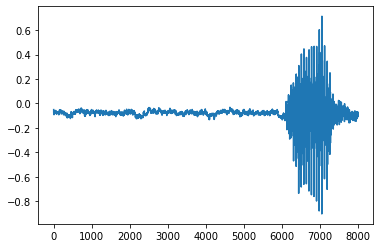

In [8]:
plt.plot(x.numpy().reshape(-1))

Creamos nuestro DataLoader

In [9]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32,shuffle=True)

Definamos nuestro modelo

In [10]:
for x,y in test_dl:
  print(x.shape)
  print(y)
  break

torch.Size([32, 1, 8000])
tensor([25, 10, 12,  1,  6,  2,  3, 32,  8, 19, 29, 26, 30, 27, 30,  6, 21, 22,
        15, 20, 30,  9, 20, 21, 25, 33, 26,  6, 20, 15, 13, 11])


In [11]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
model = nn.Sequential(
    nn.Conv1d(1,32,100,stride=40,bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.Conv1d(32,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(64,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Flatten(),
    nn.Linear(64*11,35)
).to(dev)

Entrenando nuestro modelo

In [13]:
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

In [14]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 2.377115792009086, train acc: 33.67396249543274%, test loss: 1.8036279144675234, test acc: 49.650159018627896%
epoch: 1, train loss: 1.5196780640390304, train acc: 57.2033049279257%, test loss: 1.5720648687592773, test acc: 55.0658791458428%
epoch: 2, train loss: 1.221843374923973, train acc: 65.6919250851573%, test loss: 1.2592223208657531, test acc: 63.752839618355296%
epoch: 3, train loss: 1.0550669895577753, train acc: 70.26154190681612%, test loss: 1.1218896626039994, test acc: 69.45933666515221%
epoch: 4, train loss: 0.9515540603081925, train acc: 73.23644849899226%, test loss: 0.9969441804948241, test acc: 71.84915947296683%
epoch: 5, train loss: 0.8832956628135067, train acc: 75.04449394764447%, test loss: 1.0640648035115974, test acc: 71.20399818264426%
epoch: 6, train loss: 0.8276392451317511, train acc: 76.5071956437184%, test loss: 1.5212935529822527, test acc: 62.63516583371195%
epoch: 7, train loss: 0.7811935854848154, train acc: 77.6728781396226%, t

In [15]:
torch.save(model.state_dict(),"speech_commnad_model_conv1d.ckpt")

In [73]:
model.load_state_dict(torch.load("speech_commnad_model_conv1d.ckpt"))
model.eval()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(100,), stride=(40,), bias=False)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), bias=False)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=704, out_features=35, bias=True)
)

In [75]:
idx = 2020
audio_ = Audio(data=sc_train_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(train_ds[idx][0].reshape(1,1,8000).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Bed


# Usemos Espectrogramas y Convolucion 2D para speech recognition

Backward
torch.Size([1, 8000])
-11.512923
Backward
torch.Size([1, 8000])
-11.512925


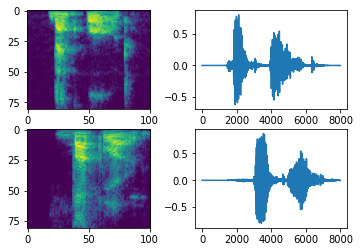

In [16]:
count = 0
idx = 0
fig, axs = plt.subplots(2,2)
for x, l in test_ds:
  if l ==idx :
    print(speech_labels[l])
    print(x.shape)
    N, l = x.shape
    y = torchaudio.transforms.Spectrogram(n_fft=160)(x)
    I=np.log(y[0].numpy() + 1e-5)
    print(np.min(I))
    axs[count,0].imshow(I)
    axs[count,1].plot(x[0].numpy())
    count += 1
    if count == 2:
      break

Definamos nuestro dataset

In [17]:
class MySpectrogramDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
    self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=160)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return self.spectrogram(self.resampling(x)), speech_dict[y]

In [78]:
train_ds = MySpectrogramDataset(sc_train_ds)
test_ds = MySpectrogramDataset(sc_test_ds)

Preparemos nuestro dataloader

In [19]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32,shuffle=True)

Definamos nuestro modelo

In [76]:
model = nn.Sequential(
  nn.Conv2d(1,16,7,bias=False),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(64*8,35)
).to(dev)

Entrenemos nuestro modelo

In [25]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 1.8738873636583218, train acc: 47.08461511261978%, test loss: 3.785495261813319, test acc: 16.583371194911404%
epoch: 1, train loss: 0.9291191263795798, train acc: 73.34016948952771%, test loss: 2.3057779603919317, test acc: 37.900954111767376%
epoch: 2, train loss: 0.7054947461444059, train acc: 79.59878835024692%, test loss: 2.1324095043332076, test acc: 39.436619718309856%
epoch: 3, train loss: 0.5932417686433049, train acc: 82.81649635208562%, test loss: 2.0738513338011364, test acc: 41.49023171285779%
epoch: 4, train loss: 0.5246588598001259, train acc: 84.76597951510436%, test loss: 2.3492763278096223, test acc: 43.44388914129941%
epoch: 5, train loss: 0.4911858556106642, train acc: 85.62521362988107%, test loss: 2.3227659356455472, test acc: 38.95502044525216%
epoch: 6, train loss: 0.4443840169408225, train acc: 86.97947974494066%, test loss: 1.895372542357722, test acc: 48.178100863243984%
epoch: 7, train loss: 0.45305606227390594, train acc: 86.7508221067

In [26]:
torch.save(model.state_dict(),"speech_command_model_spectrogram.ckpt")

In [77]:
model.load_state_dict(torch.load("speech_command_model_spectrogram.ckpt"))
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Ma

In [82]:
idx = 2001
audio_ = Audio(data=sc_train_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(train_ds[idx][0].reshape(1,1,81,101).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Bird


Usando LSTM (Long-Short term memory) para speech recognition